In [116]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

import Bargaining as brg

import numpy as np
import numba as nb
import scipy.optimize as optimize
import copy

from EconModel import EconModelClass
from consav.grids import nonlinspace
from consav import linear_interp, linear_interp_1d
from consav import quadrature

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

# c++ settings
do_cpp = False
do_compile = True
threads = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [117]:
# compile c++ files
if do_cpp & do_compile:
    model = brg.HouseholdModelClass(par={'do_cpp':do_cpp,'num_Ctot':100})
    model.link_to_cpp(force_compile=do_compile)

In [121]:
# settings for models to solve
T = 10
specs = {
    'model 1':{'latexname':'$\sigma_{\psi}=0$', 'par':{'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # 'model 2':{'latexname':'$\sigma_{\psi}=0.04$', 'par':{'sigma_love':0.04,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # 'model 3':{'latexname':'$\sigma_{\psi}=0.1$', 'par':{'sigma_love':0.1,'T':T,'do_cpp':do_cpp,'threads':threads}},
    # 'model 4':{'latexname':'$\kappa_w=0.3$', 'par':{'div_A_share':0.3,'sigma_love':0.0,'T':T,'do_cpp':do_cpp,'threads':threads}},
}


In [122]:
# solve different models
models = {}
for name,spec in specs.items():
    print(f'solving {name}...')
    
    # setup model
    models[name] = brg.HouseholdModelClass(name=name,par=spec['par'])
    if do_cpp: models[name].link_to_cpp(force_compile=False)
    models[name].spec = spec
    
    # solve
    models[name].solve()

solving model 1...


In [124]:
# Set index
t=4
iP=10
iL=20
iA=10
idx_couple = lambda iP: (t,iP,iL,iA)
idx_single = (t,iA)

# Unpack lists
remain_Vw = sol.Vw_remain_couple[t,:,iL,iA]
remain_Vm = sol.Vm_remain_couple[t,:,iL,iA]
remain_Cw_priv = sol.Cw_priv_remain_couple[t,:,iL,iA]
remain_Cm_priv = sol.Cm_priv_remain_couple[t,:,iL,iA]
remain_C_pub = sol.C_pub_remain_couple[t,:,iL,iA]

list_couple = copy.deepcopy((sol.Vw_couple,sol.Vm_couple,sol.Cw_priv_couple,sol.Cm_priv_couple,sol.C_pub_couple))
list_raw = copy.deepcopy((remain_Vw,remain_Vm,remain_Cw_priv,remain_Cm_priv,remain_C_pub))
list_single = copy.deepcopy((sol.Vw_single,sol.Vm_single,sol.Cw_priv_single,sol.Cm_priv_single,sol.Cw_pub_single)) # last input here not important in case of divorce

# Get power variables
power_idx = copy.deepcopy(sol.power_idx)
power = copy.deepcopy(sol.power)

# Calculate surplus
Sw = sol.Vw_remain_couple[t,:,iL,iA]-sol.Vw_single[idx_single]
Sm = sol.Vm_remain_couple[t,:,iL,iA]-sol.Vm_single[idx_single]

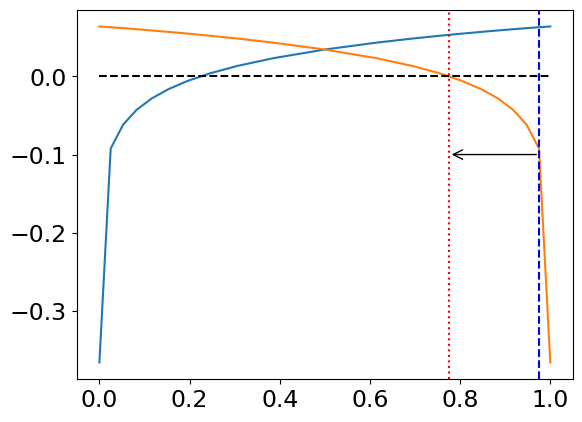

In [128]:
def plot_surplus(par, Sw, Sm, start_power_idx, index_couple, power):
    plt.plot(par.grid_power,Sw)
    plt.plot(par.grid_power,Sm)
    plt.plot(par.grid_power,np.zeros(par.num_power), color=
            'black',linestyle='--')
    #add vertical line at start_power
    start_power = par.grid_power[start_power_idx]
    plt.axvline(x=start_power, color='blue',linestyle='--')

    #add vertical line at end_power if it exists
    end_power = power[index_couple(start_power_idx)]
    if end_power > 0:
        plt.axvline(x=end_power, color='red',linestyle=':')

        # make a one directional arrow from start_power to end_power lower than the x axis
        plt.annotate("", xy=(end_power, -0.1), xytext=(start_power, -0.1), arrowprops=dict(arrowstyle="->"))
    

plot_surplus(par, Sw, Sm, -2, idx_couple, power)